In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv("s:\\dataProjects\\ato\\removeMeTrain\\merged.txt")
print len(df)

4170


In [3]:
# the merge would have added a header to each line, 
# remove those, the first line is used for column names anyway
# so this works nicely
df = df[df.eventId != "eventId"]

In [4]:
# drop a few of the problematic, single value categorical vars, unqiue entries and for now IP address
dfclean = df.drop(['eventId', 'eventCreationTime', 'userIpAddress', 'pool_name_for_command'], axis=1)

In [5]:
# fill in all empty values/NaN with 0.0
dfclean = dfclean.fillna(0.0)

In [6]:
# lets peek at the data
dfclean.head()

,eventType,userId,is_machine_blacklisted_ato_same_seller,is_machine_blacklist_cancelled_same_seller,is_ip_trusted,is_machine_blacklisted_ato,is_machine_blacklist_cancelled,is_machine_suspicious,is_user_suspicious,suspicious_ip_failed_metric,suspicious_ip_success_metric,count_of_whitelisted_machines_for_user,difference_guid_time_event_creation_time,difference_machine_creation_time_event_creation_time,difference_user_creation_date_with_baseline,difference_seller_creation_date_with_baseline,is_timezone_valid,email_changed_type,password_changed_type,contact_info_changed_type,password_hint_changed_type,primary_phone_changed_type,secondary_phone_changed_type,contact_info_history_changed_type,answer_to_secret_question_changed_type,does_email_domain_have_country_top_level_domain,is_email_domain_free,normalized_feedback_score,24hr_failed_signin_attempts_from_ip,24hr_failed_signin_attempts_from_user,have_seen_exact_browser_signature_for_user,exact_browser_match_usage_ratio,approx_browser_signature_match_score,approx_browser_close_name_match_distance,approx_browser_close_name_match_usage,approx_browser_close_version_match_distance,approx_browser_close_version_match_usage,approx_browser_close_os_match_distance,approx_browser_close_os_match_usage,is_command_match_found_in_lookup,command_usage_ratio,unique_command_count,is_guid_host_match_found_in_lookup,guid_host_usage_ratio,unique_guid_host_count,geographic_distance_between_signin_ip_zip,geographic_distance_between_signin_ip_registered_ip,is_signin_ip_user_registered_site_id_match,signin_ip3_active_days_for_user,signin_ip2_active_days_for_user,unique_ip3_count_for_user,unique_ip2_count_for_user,days_region_has_been_active_for_user,region_usage_proportion_by_user,unique_geographic_region_count_for_user,country_usage_proportion_by_user,untrusted_machine_count_ratio,new_machine_count_ratio,old_machine_count_ratio,unique_machine_age_count,is_signin_siteId_user_registered_siteId_match,usage_ratio_of_current_signin_site_by_user,has_site_been_used_by_user,site_usage_ratio,days_since_current_site_last_used,count_of_unique_sites_used_by_user,has_time_zone_been_used_by_user,time_zone_usage_ratio,count_of_unique_time_zones_used_by_user,current_application_id,score,label
0,55,1073465719,0,0,0,0,0,0,0,0,0,0,1,-1,6,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,3,2,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,1,-1,0,-1,-1.0,-1,0,-1,-1,0,0.3916509542491386,1
1,53,1073465719,0,0,0,0,0,0,0,0,0,0,4,1,6,-1,0,-1,-1,-1,-1,-1,-1,-1,4,0,0,1,3,3,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,1,-1,0,-1,-1.0,-1,0,-1,-1,0,0.6036493056916882,1
2,55,1073465719,0,0,0,0,0,0,0,0,0,0,1,-1,6,-1,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,2,2,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,1,-1,0,-1,-1.0,-1,0,-1,-1,0,0.4053142987993179,1
3,53,1056092400,0,0,0,0,0,0,0,0,0,0,1,1,6,6,0,-1,-1,-1,4,-1,-1,-1,-1,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,1,-1,0,-1,-1.0,-1,0,-1,-1,0,0.17300336012858572,1
4,53,1073465719,0,0,0,0,0,0,0,0,0,0,1,1,6,-1,0,-1,-1,-1,-1,-1,-1,-1,4,0,0,1,3,3,0,0,0,0,0,0,0,0,0,0,-1,-1,0,-1,-1,-1,-1,0,0,0,0,0,0,0,0,0,-1,-1,-1,-1,1,-1,0,-1,-1.0,-1,0,-1,-1,0,0.46401421369758594,1


In [7]:
# time to do some learning 

# lets start by shuffle the data around
dfclean = dfclean.reindex(np.random.permutation(dfclean.index))

# take first quarter of the entries for training, rest testing
testSize = len(dfclean)/4
test = dfclean[0:testSize]
train = dfclean[testSize:]

print "Training: ", len(dfclean)-testSize, " Testing: ", testSize, "\n\n"

# lets keep the scores for later
trainScores = train['score']
trainY = train['label']
trainX = train.drop(['label', 'score'], axis=1)

testScore = test['score']
testY = test['label']
testX = test.drop(['label', 'score'], axis=1)

# rf business
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)

clf.fit(trainX, trainY)
pred = clf.predict(testX)
pred_prob = clf.predict_proba(testX)[:,1]

# metrics
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(testY, pred_prob, pos_label='1')
auc = metrics.auc(fpr, tpr)

print "accuracy: ", metrics.accuracy_score(testY, pred)
print "mathews: ", metrics.matthews_corrcoef(testY, pred)
print "f1 score: ", metrics.f1_score(testY, pred,pos_label='1')
print "auc: ", auc
print "\n\nclassification report: \n", metrics.classification_report(testY, pred)

# TODO: Perhaps auc curve

Training:  3095  Testing:  1031 


accuracy:  0.80407371484
mathews:  0.608830768585
f1 score:  0.818671454219
auc:  0.890487117461


classification report: 
             precision    recall  f1-score   support

          0       0.83      0.75      0.79       497
          1       0.79      0.85      0.82       534

avg / total       0.81      0.80      0.80      1031



                                          featureName  featureImportance
1                                              userId           0.266200
27                          normalized_feedback_score           0.165405
13  difference_machine_creation_time_event_creatio...           0.099660
12           difference_guid_time_event_creation_time           0.079271
29              24hr_failed_signin_attempts_from_user           0.058954
28                24hr_failed_signin_attempts_from_ip           0.056120
47         is_signin_ip_user_registered_site_id_match           0.046412
15      difference_seller_creation_date_with_baseline           0.028164
21                         primary_phone_changed_type           0.027642
4                                       is_ip_trusted           0.022548
60      is_signin_siteId_user_registered_siteId_match           0.022500
0                                           eventType           0.021833
22                       secondary_phone_changed_ty

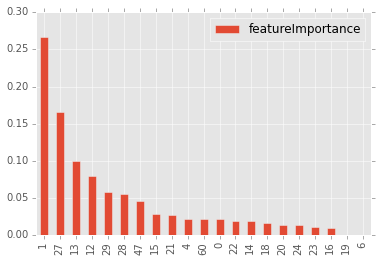

In [8]:
#Feature importanace
# join feature importance and name into a df
featImportance = pd.DataFrame(zip(dfclean.columns, clf.feature_importances_), columns=['featureName', 'featureImportance'])

# sort them 
sortedFeatImport = featImportance.sort(columns=['featureImportance'], ascending=False)
# print them sorted
print sortedFeatImport

# plot those features with > 0.0001 contribution as a bar graph
sortedFeatImport[sortedFeatImport.featureImportance > 0.0001].plot(kind="bar")

In [9]:
# what happens when we removed muted variables?

# remove secrete question
trainX = trainX.drop(['answer_to_secret_question_changed_type', 'password_hint_changed_type'], axis=1)
testX = testX.drop(['answer_to_secret_question_changed_type', 'password_hint_changed_type'], axis=1)

# rf business
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)

clf.fit(trainX, trainY)
pred = clf.predict(testX)
pred_prob = clf.predict_proba(testX)[:,1]

# metrics
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(testY, pred_prob, pos_label='1')
auc = metrics.auc(fpr, tpr)

print "accuracy: ", metrics.accuracy_score(testY, pred)
print "mathews: ", metrics.matthews_corrcoef(testY, pred)
print "f1 score: ", metrics.f1_score(testY, pred,pos_label='1')
print "auc: ", auc
print "\n\nclassification report: \n", metrics.classification_report(testY, pred)


accuracy:  0.808923375364
mathews:  0.618377221666
f1 score:  0.822682268227
auc:  0.894690238811


classification report: 
             precision    recall  f1-score   support

          0       0.83      0.76      0.79       497
          1       0.79      0.86      0.82       534

avg / total       0.81      0.81      0.81      1031



In [10]:

# remove phones and contact details
trainX = trainX.drop(['secondary_phone_changed_type', 'primary_phone_changed_type', 'contact_info_changed_type', 'contact_info_history_changed_type'], axis=1)
testX = testX.drop(['secondary_phone_changed_type', 'primary_phone_changed_type', 'contact_info_changed_type', 'contact_info_history_changed_type'], axis=1)

# rf business
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200)

clf.fit(trainX, trainY)
pred = clf.predict(testX)
pred_prob = clf.predict_proba(testX)[:,1]

# metrics
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(testY, pred_prob, pos_label='1')
auc = metrics.auc(fpr, tpr)

print "accuracy: ", metrics.accuracy_score(testY, pred)
print "mathews: ", metrics.matthews_corrcoef(testY, pred)
print "f1 score: ", metrics.f1_score(testY, pred,pos_label='1')
print "auc: ", auc
print "\n\nclassification report: \n", metrics.classification_report(testY, pred)


accuracy:  0.797284190107
mathews:  0.594100713924
f1 score:  0.809132420091
auc:  0.880479506251


classification report: 
             precision    recall  f1-score   support

          0       0.81      0.76      0.78       497
          1       0.79      0.83      0.81       534

avg / total       0.80      0.80      0.80      1031



In [ ]:
# how do the old scores compare to the new model?

In [ ]:
# what is the score distribution using the old model vs new model

In [ ]:
# score a large volume, say a day's data, how much would we reduce needless KG by?